# HW 2: Intro to CNN's with Keras

### Introduction
In this notebook we'll be working with Convolutional Neural Networks (CNNs), a class of neural network that works particularly well with image data by filtering* (convolving). CNNs are a way to focus training on a subset of information, nullifying unimportant features. In theory, you can use a CNN wherever you use a vanilla neural net (with some restrictions). However, depending on your data, your mileage on speed and accuracy may vary. For images, we know CNNs tend to perform better and even for some speech problems a 1D CNN can be useful.

We'll mainly be looking at image data, all similar to data we used in the *Introduction to Keras* notebook. That way, we may concentrate on learning CNNs rather than learn about new data.

*note: By filtering, we mean, for example, adding a blurring effect (or a blur filter) onto an image. This might make understanding an image harder to us humans, but it makes it easier for a computer to understand and learn. Different filters work for di

### A note about training:
Training locally might take a long while. CNNs are more computationally expensive and we are dealing with deeper networks, meaning training is no longer fast. As an example, running locally the first CNN model in this notebook took a couple of minutes per epoch. Colab's GPU, under 15 seconds per epoch. I highly recommend you do this on a GPU to speed up your results rather than waste potentially hours training.

If on Colab, make your runtimes with a GPU by clicking on Runtime, Change runtime, and click on the dropdown menu to GPU.

## Revenge of Fashion MNIST
In the previous notebook, we asked to train a simple neural network on a dataset known as Fashion MNIST. If you remember, getting results near or above the high 80%s was pretty difficult. Here we will show how CNNs fair when attacking this problem.

### Imports

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
# I am assuming tensorflow is installed in your machine since the last 
# notebook. However, if you need it installed again, unmute and run below
# !pip install tensorflow

For reproducible (and grading purposes)

In [22]:
from numpy.random import seed
seed(42)
from tensorflow.random import set_seed
set_seed(42)
#If the two lines above give you error, mute them and run the following:
# import tensorflow
# tensorflow.random.set_seed(42)

## Loading and Preprocessing

In [23]:
# Loading datasets
fashion = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion.load_data()

# Setting labels
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", 
         "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Seeing shapes of data
print("X_train:", X_train_full.shape)
print("y_train:", y_train_full.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (60000, 28, 28)
y_train: (60000,)
X_test: (10000, 28, 28)
y_test: (10000,)


In case you would like to see how this data looks like again:

The expected value is: Trouser


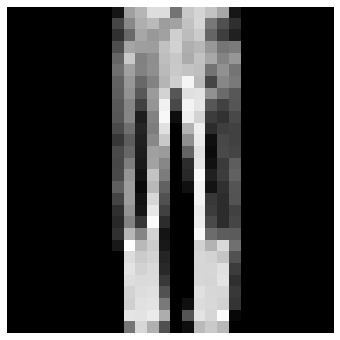

In [24]:
# Rerun to get different images
def plotImage(image):
    """A 28x28 array that represents an image."""
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap="gray")
    plt.axis(False)
    plt.show()
sample_image = np.random.randint(0, len(X_train_full))
print("The expected value is:", labels[y_train_full[sample_image]])
plotImage(X_train_full[sample_image])

Splitting our data into Train / Validate / Test and normalizing/scale our data (preprocessing in order to obtain better results).

In [25]:
X_valid, X_train = X_train_full[:5000] / 255, X_train_full[5000:] / 255
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255
#No need to do y_test since it's not being fed into the data.
#Also, data is already shuffled, so no need to do so here

Lastly, CNNs input a 3D tensor (for a 2D convolution). The current shape of our input data:

In [26]:
X_train.shape

(55000, 28, 28)

is 2D, 28x28 (the 55000 is the number of images saved to the variable). So we reshape our input data using this trick:

In [27]:
def reshape_2D_to_3D(X):
    """Reshape variable from 2D to 3D of an X of shape (length, x, y) by adding 
    a 1 as a dimension in numpy's reshape function to out (length, x, y, color 
    channel).
    """
    return np.reshape(X, (X.shape[0], X.shape[1], X.shape[2], 1))
X_train = reshape_2D_to_3D(X_train)
X_valid = reshape_2D_to_3D(X_valid)
X_test = reshape_2D_to_3D(X_test)

Now we're ready to create a CNN

## Sign Language MNIST

### Loading and Some Preprocessing

You're going to be using a sign language dataset to predict letters in the American sign language alphabet. The dataset can be downloaded through [kaggle](https://www.kaggle.com/datamunge/sign-language-mnist) but if you don't have a Kaggle account, you may download it through [here](https://drive.google.com/drive/folders/1miNKEZ4hbimO9dW87eW4j0vfv_RHQld1?usp=sharing).

You're going to have to find a way to read in your data. Locally isn't much of an issue, however reading your data through Colab or Kaggle could be problematic. I've followed [this tutorial](https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971) on getting data onto Colab and have muted the cells below, but please ignore them and look elsewhere to upload your data if you're not using Colab.

### Problem 0: Load the data

In [28]:
from google.colab import drive
drive.mount("/content/gdrive")

ModuleNotFoundError: No module named 'google.colab'

In [29]:
import pandas as pd
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 
            'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
X_train_full = pd.read_csv('/content/gdrive/My Drive/archive/sign_mnist_train/sign_mnist_train.csv') #TODO: Change your path here
X_test_full = pd.read_csv('/content/gdrive/My Drive/archive/sign_mnist_train/sign_mnist_train.csv') #TODO: Chainge your path here
X_train_full.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/My Drive/archive/sign_mnist_train/sign_mnist_train.csv'

Our dataset containts 785 columns, 784 for pixels and one column for labels (alphabet). Let's extract our labels and drop the label column.

In [30]:
y_train_full = X_train_full['label']
y_test_full = X_test_full['label']
X_train_full.drop(labels=['label'], axis=1, inplace=True)
X_test_full.drop(labels=['label'], axis=1, inplace=True)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

We'll now use sklearn to shuffle and break our data into train/val. We previously didn't need to do this since our data came shuffled but in this case, it isn't. We'll also convert our pandas DataFrame to our more familiary numpy array. While training DataFrames are possible in Tensorflow, for consistency and flexibility, we'll stick with numpy arrays.

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)
# Feel free to change test size


# Converting to numpy arrays
def pandas_to_array(X, shape):
  """Convert a pandas array into numpy. Shape is in the form of a tuple"""
  return X.to_numpy().reshape(len(X), *shape)

shape = (28, 28)
X_train = pandas_to_array(X_train, (shape))
X_valid = pandas_to_array(X_valid, (shape))
y_train = y_train.to_numpy()
y_valid = y_valid.to_numpy()

# Also converting our test data
X_test = pandas_to_array(X_test_full, shape)
y_test = y_test_full.to_numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

Let's plot this to see our data. For reference, [here's a link to a sign language alphabet](https://www.startasl.com/wp-content/uploads/asl-alphabet_wallpaper_1920x1200.png).

The expected letter is: f


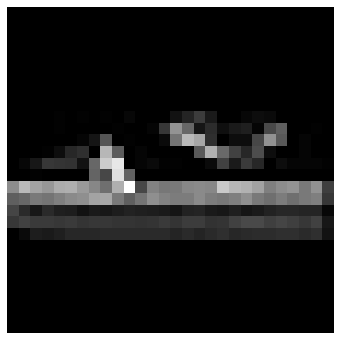

In [32]:
# Rerun to get different images
def plotImage(image):
    """A 28x28 array that represents an image."""
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap="gray")
    plt.axis(False)
    plt.show()
sample_image = np.random.randint(0, len(X_train))
print("The expected letter is:", alphabet[y_train[sample_image]])
plotImage(X_train[sample_image])

A note about ASL: two of it's letters, j and z, are movements. As such, these letters are not represented in our dataset. As proof, finding all labels in y_train:

In [33]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

The values 9 and 25 are missing from this set, which are both j and z respectively.

In [34]:
print(alphabet[9])
print(alphabet[25])

j
z


### Problem 1: Finish preprocessing

Finish scaling the data and reshaping it so that it is appropriate for a CNN.

In [14]:
# TODO: Scale data

In [ ]:
# TODO: Reshape data

### Problem 2: Create a CNN model
Create, compile, and train a CNN model


In [15]:
# TODO: Create CNN, several cells added below in case needed

## Problem 3: Analyze Error
Produce a confusion matrix and report the most misrepresented label that your model perdicted. Could you give a hypothesis for why this label was so badly predicted?

In [16]:
# TODO: Create confusion matrix

In [ ]:
# Hint: If you're planning on making the colorplot, make labels=alphabet in 

In [17]:
# plt.xticks and plt.yticks. You may need to take out j and z

## Problem 4: Score your data
Score your data using X_test. Are there signs of overfitting?

In [18]:
# TODO: Score X_test

## Bonus - Problem 5: Predict Your Own Letter
Now that you have a model, let's see if it can predict a letter you give it. Take a picture of you doing any letter (besides j and z) on a semi-light background (look at examples through the sign language dataset to get close to the format of how their image is taken) and convert it into a png file. Find the path of the image and input it into the function below. This function will convert an image into the MNIST format.

You may need to play around with image paths if on something like Colab. Follow the same steps as loading the sign language dataset to get a path that can be routed to your image.

In [19]:
# Credits to: https://stackoverflow.com/questions/35842274/convert-own-image-to-mnists-image
# Function to convert a png location to a pixel-MNIST style image.
from PIL import Image, ImageFilter #pip install if needed

def imageprepare(argv):
    """
    This function returns the pixel values.
    The imput is a png file location.
    """
    im = Image.open(argv).convert('L')
    width = float(im.size[0])
    height = float(im.size[1])
    newImage = Image.new('L', (28, 28), (255))  # creates white canvas of 28x28 pixels

    if width > height:  # check which dimension is bigger
        # Width is bigger. Width becomes 20 pixels.
        nheight = int(round((20.0 / width * height), 0))  # resize height according to ratio width
        if (nheight == 0):  # rare case but minimum is 1 pixel
            nheight = 1
            # resize and sharpen
        img = im.resize((20, nheight), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wtop = int(round(((28 - nheight) / 2), 0))  # calculate horizontal position
        newImage.paste(img, (4, wtop))  # paste resized image on white canvas
    else:
        # Height is bigger. Heigth becomes 20 pixels.
        nwidth = int(round((20.0 / height * width), 0))  # resize width according to ratio height
        if (nwidth == 0):  # rare case but minimum is 1 pixel
            nwidth = 1
            # resize and sharpen
        img = im.resize((nwidth, 20), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wleft = int(round(((28 - nwidth) / 2), 0))  # caculate vertical pozition
        newImage.paste(img, (wleft, 4))  # paste resized image on white canvas

    # newImage.save("sample.png

    tv = list(newImage.getdata())  # get pixel values

    # normalize pixels to 0 and 1. 0 is pure white, 1 is pure black.
    tva = [(255 - x) * 1.0 / 255.0 for x in tv]
    print(tva)
    return np.array(tva).reshape(28, 28, 1)



your_image = imageprepare('') # TODO: file path here
print(len(your_image.shape))

AttributeError: 'str' object has no attribute 'read'

In [20]:
# Predict with your model your image
# model.predict(your_image) # Change model to whatever you named your model to.

Did your model predict correctly? If not, why do you think so?

## Submission

Once you're ready to submit, turn in a copy of this Jupyter notebook and a PDF copy of it. For the PDF, please label the pages of problems 1, 2, 3, 4, and (optionally) 5.

Locally, there should a "Download as" under "File" and PDF should be an option. 

If you're doing this assignment using Colab, Colab does not have this PDF option. I recommend downloading and openning this notebook using IPython/Jupyter Notebook locally and doing the instruction above (with the automatic saved inputs). If you're resistant to this option, there are other options. If you're on a Mac, a hack you can do is to print this page and before you print, save the file as a PDF instead of printing. 

An alternative is to save your Colab notebook as an HTML file and convert that into a PDF (using a third party website like https://html2pdf.com/ or a browser extension like https://chrome.google.com/webstore/detail/web-page-to-pdf-converter/bbfoccanbdeldjaelafmbgonagegdndg). Converting HTMLs into PDFs tends to be easier/more common than ipynb to PDFs. If you need additional help, please feel free to Slack Kevin or Jess for aid!